# Kaggle Invasive Species Competition

This notebook creates invasive plant species classifier using  pictures of shrubs. Data is from an old Kaggle competition ([see here](https://www.kaggle.com/c/invasive-species-monitoring)). I used a convolutional neural network using the resnet34 architecture. Weight files for the model arcitechture resnet34 must be downloaded from # weights files must be downloaded http://files.fast.ai/models/weights.tgz and placed in the fastai folder.

The baseline model is just resnet34 trained for 20 epochs. This was able to achieve an accuracy of about 91% on the validation set. Using the learning rate finder to find the optimal learning rate, data augmentation, learning rate annealing with restart, I was able to achieve an accuracy of about 98%.


## 1. Load Modules and Set Parameters

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys; sys.path.append('../fastai')

In [4]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [5]:
PATH = "/home/pspenano/Dropbox/data_science/fastai_deeplearning/pt1/data/invasive-species-monitoring"

In [11]:
os.listdir(PATH)

['sample_submission.csv.zip',
 'test.7z',
 'train',
 'train.7z',
 'train_labels.csv',
 'train_labels.csv.zip',
 '__MACOSX']

## 2. Prepare and analyze data


In [16]:
label_csv = f"{PATH}/train_labels.csv"
label_df = pd.read_csv(label_csv)
label_df['invasive'].unique()

array([0, 1])

Number of observations in training

In [17]:
label_df.shape

(2295, 2)

In [18]:
label_df.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [87]:
label_df.describe()

,name,invasive
count,2295.000000,2295.000000
mean,1148.000000,0.630937
std,662.653756,0.482656
min,1.000000,0.000000
25%,574.500000,0.000000
50%,1148.000000,1.000000
75%,1721.500000,1.000000
max,2295.000000,1.000000


Classes are pretty balanced so using accuracy as the metric should be okay

In [19]:
label_df[label_df.name==100]

,name,invasive
99,100,1


In [20]:
label_df['img_file_name'] = label_df['name'].astype(str) + '.jpg'

In [21]:
label_df.head()

,name,invasive,img_file_name
0,1,0,1.jpg
1,2,0,2.jpg
2,3,1,3.jpg
3,4,0,4.jpg
4,5,1,5.jpg


In [29]:
invasive_df = label_df[label_df.invasive == 1]
noninvasive_df = label_df[label_df.invasive == 1]

A 1 under invasive column indicates that the image contains an invasive species. Lets look at some invasive and non-invasive species images

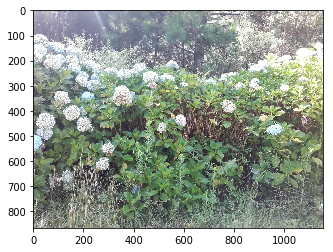

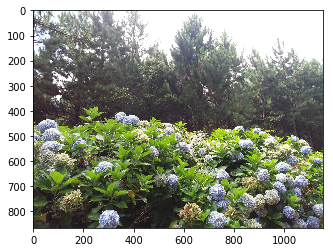

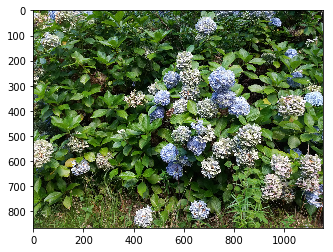

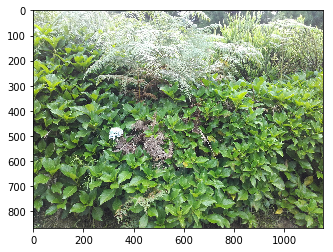

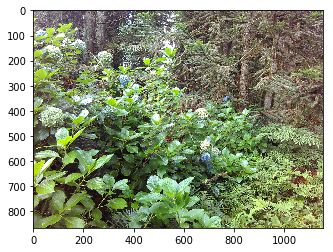

In [80]:
# invasive
for spc in invasive_df['img_file_name'].head(n=5):
    img = plt.imread(f'{PATH}/train/{spc}')
    plt.imshow(img)
    plt.show()

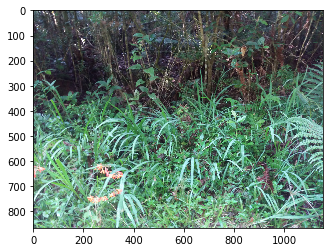

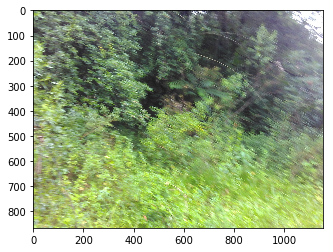

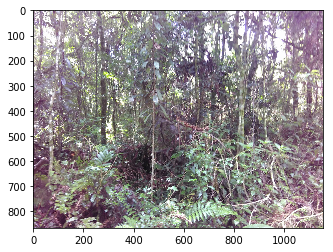

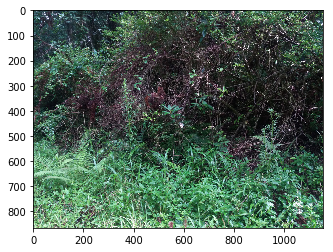

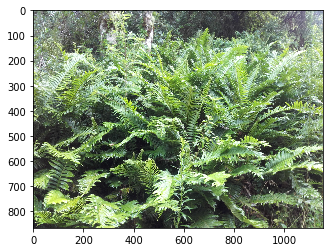

In [81]:
# non-invasive
for spc in noninvasive_df['img_file_name'].head(n=5):
    img = plt.imread(f'{PATH}/train/{spc}')
    plt.imshow(img)
    plt.show()

How big are these images? Get image dimensions in training set

In [39]:
img_files = os.listdir(f'{PATH}/train')
y_dim = [plt.imread(f'{PATH}/train/{img}').shape[0] for img in img_files]

In [40]:
x_dim = [plt.imread(f'{PATH}/train/{img}').shape[1] for img in img_files]

In [41]:
set(y_dim)

{866}

In [42]:
set(x_dim)

{1154}

All images in training have same dimension, namely 866x1154 RGB images.

## 3. Estimate model

In [52]:
arch = resnet34  # which architecture?
sz = 224  # resize image to this size (how to choose?)  

In [53]:
# prepare data and get index for validation data
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)
val_idxs.shape

(459,)

### 3.1 Baseline

Get baseline model without any optmization. Learning rate chosen arbitrarily.

In [86]:
tfms = tfms_from_model(arch,sz)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}/train_labels.csv',tfms=tfms, val_idxs=val_idxs, suffix='.jpg')
learn_baseline = ConvLearner.pretrained(arch, data, precompute=True)
learn_baseline.fit(0.01, 20)
learn_baseline.save('224_quickmodel')

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.364133   0.245333   0.891335  
    1      0.27577    0.217985   0.916371  
    2      0.222044   0.206463   0.910866  
    3      0.195269   0.202259   0.92223   
    4      0.185107   0.212817   0.920277  
    5      0.169857   0.201087   0.918324  
    6      0.160201   0.191245   0.916726  
    7      0.144345   0.196084   0.926136  
    8      0.133063   0.183668   0.916726  
    9      0.123987   0.189716   0.928089  
    10     0.118593   0.188426   0.926136  
    11     0.111616   0.186121   0.931996  
    12     0.107934   0.206745   0.926136  
    13     0.107116   0.195008   0.926136  
    14     0.101339   0.178298   0.935902  
    15     0.094484   0.177768   0.924183  
    16     0.093059   0.18457    0.928089  
    17     0.092228   0.188505   0.924183  
    18     0.083191   0.189303   0.926136  
    19     0.078368   0.188012   0.931996  



### 3.2 Improved
* Use learning rate finder
* Pretrain final layer with precompute = True 
* Train last layer with data augmentation and cycle_len=1
* Unfreeze all layers and train with differential learning rates (use learning rates that are about 10x than next highest layer given image type

In [71]:
# define get data function

def get_data(sz):

    tfms = tfms_from_model(arch,
                           sz,
                           aug_tfms=transforms_side_on,
                           max_zoom=1.1)

    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}/train_labels.csv', 
                                        tfms=tfms, val_idxs=val_idxs, suffix='.jpg')
    
    return data

#### Find LR

In [72]:
data = get_data(sz)
find_lr_learner = ConvLearner.pretrained(arch, data, precompute=True)
lrf = find_lr_learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 52%|█████▏    | 15/29 [00:00<00:00, 54.51it/s, loss=2.93]


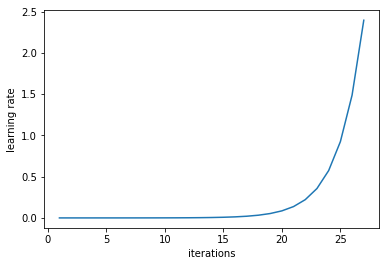

In [60]:
find_lr_learner.sched.plot_lr()

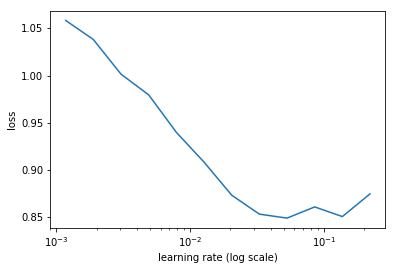

In [61]:
find_lr_learner.sched.plot()

A reasonable optimal LR appears to be about 0.0125

In [73]:
lr = 1.25e-2

#### Train final layer with precompute=True

In [74]:
data = get_data(sz)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.373308   0.240523   0.900746  
    1      0.260206   0.205675   0.910511  



[0.20567486, 0.9105113670229912]

With new learning rate, we a achieved a slightly better accuracy on the validation set.

#### Train last layer with data augmentation

We turn off precompute to allow data augmentation in training. We set cycle_len=1, to use learning rate restarts. This improves learning performance by increasing the chance of finding a stable local optima. It uses cosine annealing to gradually decrease the learning rate after each iteration and reset it back to its original value after each epoch.

In [75]:
learn.precompute = False
learn.fit(lr, 3, cycle_len=1)
learn.save('224_lastlayer_precomputeFalse')
learn.load('224_lastlayer_precomputeFalse')

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.236606   0.236843   0.896839  
    1      0.244397   0.219581   0.908558  
    2      0.228504   0.207438   0.910511  



The model as begun to overfit. Training loss decreased while validation loss increased.

#### Unfreeze and train entire model

In [76]:
learn.unfreeze()
lra = np.array([lr/100, lr/10, lr])
learn.fit(lra, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.323519   0.255217   0.883878  
    1      0.23808    0.165299   0.926491  
    2      0.20716    0.149012   0.926491  
    3      0.168484   0.125809   0.943714  
    4      0.132866   0.106056   0.962891  
    5      0.102211   0.104492   0.962891  
    6      0.09004    0.100357   0.970703  



[0.10035673, 0.970703125]

Validation is still improving, looks like we can continue training this for a few more epochs

In [77]:
learn.fit(lra, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.071543   0.105741   0.955433  
    1      0.075516   0.094138   0.970703  
    2      0.085017   0.087879   0.972656  



[0.08787924, 0.97265625]

In [78]:
learn.fit(lra, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.044996   0.087689   0.96875   
    1      0.055653   0.085789   0.972656  
    2      0.048338   0.084154   0.974609  
    3      0.042078   0.073214   0.976562  
    4      0.040137   0.069391   0.978516  
    5      0.035444   0.072721   0.976562  
    6      0.029241   0.070056   0.978516  



[0.070055924, 0.978515625]

In [79]:
learn.fit(lra, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.041733   0.072206   0.974609  
    1      0.04151    0.066951   0.984375  
    2      0.03491    0.067499   0.982422  
    3      0.03068    0.075374   0.982422  
    4      0.030197   0.074306   0.980469  
    5      0.025496   0.073145   0.982422  
    6      0.02437    0.073015   0.980469  



[0.073014736, 0.98046875]